# Pairs-Trading (Mean Reversion) Strategy Analysis

Pair Trading Mean Reversion strategy is a market-neutral trading strategy that involves simultaneously buying and selling two correlated financial instruments, such as stocks, ETFs, or currencies, to profit from the relative price movement between them. Here's how it works:

- **Identifying a Pair**: Select two assets that historically show a strong correlation or co-movement. The idea is that the prices of these assets tend to move together over time.
- **Determining the Spread**: Calculate the spread between the prices of the two assets. The spread is typically the difference in their prices or the difference in their log prices.
- **Mean Reversion Hypothesis**: The strategy is based on the assumption that the spread between the two assets will revert to its historical mean or average level over time. When the spread deviates significantly from this mean, it presents a trading opportunity.
- **Trade Execution**:
    - ***Long-Short Position***: When the spread widens beyond a certain threshold, the trader sells the overpriced asset (short position) and buys the underpriced asset (long position). The expectation is that the spread will narrow, and the prices will converge.
    - ***Closing the Position***: Once the spread reverts to the mean, the positions are closed. The profit is realized from the convergence of the spread.

In this notebook, the pair trading mean reversion strategy is demonstrated using cryptocurrency price data sourced from the Binance, OKX, and Bybit APIs.

## Credits

The original notebook is from the [quant_research](https://github.com/adamd1985/quant_research) repository by [adamd1985](https://github.com/adamd1985). I want to extend my sincere gratitude to this user for creating this valuable resource. The original work provided the core portion of what I built upon. I have made modifications on the data handling and visual presentation.


## Prepare your Environment

Ensure that the 'venv' kernel is selected for this notebook. If not, click on 'Kernel' at the top bar, select 'Change Kernel...' and select 'venv' as the kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [3]:
pip install -r requirements.txt

You should consider upgrading via the '/Users/gordon.oh/Desktop/quant_research/venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
from utils import calculate_profit, plot_strategy
from data_manager import load_ts_df, process_data, sanitize_data

## Process Price Dataframe

- Before proceeding, ensure that the price data has been downloaded using ***'data_manager.py'***.
- Enter the ***cex*** (Centralized Exchange) and ***interval*** values used for data download to load the relevant *.pkl* files and retrieve the dataframe.
- You can specify a batch of pairs to load using the ***selected_pairs*** variable. If no pairs are selected, all available pairs will be loaded by default.
- Note that some pairs might be new and may lack sufficient data within the downloaded timeframe. Such pairs will be removed based on the ***nan_remove_threshold*** setting, which defines the maximum percentage of NaN values allowed relative to the total data points. For example, with a ***nan_remove_threshold*** of 0.1, if a pair has 100 data points and 15 are NaN, the pair will be excluded.
- From the remaining pairs, you can filter the top N volume pairs using the ***top_n_volume_pairs*** parameter.
- This part of the code will also ensure that all timeseries columns have the same number of data points.
- The earliest and latest dates for all pairs will be recorded. These dates can then be used to determine the timeframe for slicing the data in the next step.

### Inputs

In [43]:
##### INPUTS #####
cex = 'binance'
interval = '1d'
nan_remove_threshold = 0.1

# Select only the pairs below to analyse. All pairs will be selected if the list is empty.
selected_pairs = []

# Select only the top N mean volume pairs from the selected pairs to analyse.
top_n_volume_pairs = 50

# Select volume filter mode. Options: ['rolling', 'mean'].
volume_filter_mode = 'rolling'
##################

In [44]:
print("\nMode: Pairs-Trading (Mean Reversion) Strategy")
print("CEX: {}".format(str(cex).capitalize()))
print("Interval: {}".format(interval))
print("NaN Remove Threshold: {}".format(nan_remove_threshold))
print("Selected pairs to analyse: {}".format(selected_pairs))
print("Top N Volume Pairs: {}".format(top_n_volume_pairs))
print("Volume Filter Mode: {}".format(str(volume_filter_mode).capitalize()))

merged_df = process_data('mean_reversion', cex, interval, nan_remove_threshold, selected_pairs,
                 top_n_volume_pairs, volume_filter_mode)

print("\n")


Mode: Pairs-Trading (Mean Reversion) Strategy
CEX: Binance
Interval: 1d
NaN Remove Threshold: 0.1
Selected pairs to analyse: []
Top N Volume Pairs: 50

Columns that contains NaN values:
          Pair  NaN Count          Remark
42     ZROUSDT        336       To Remove
76   LISTAUSDT        336       To Remove
26     MEWUSDT        333       To Remove
80      ZKUSDT        333       To Remove
84      IOUSDT        327       To Remove
..         ...        ...             ...
92     YGGUSDT         16  To Interpolate
33    AGLDUSDT          9  To Interpolate
16    ARKMUSDT          8  To Interpolate
44  PENDLEUSDT          8  To Interpolate
13     WLDUSDT          4  To Interpolate

[94 rows x 3 columns]

Removed 84 pairs as they contain too many NaN values.

Filtered top 50 mean volume pairs.
Successfully loaded candlestick dataframe for all available pairs.

Earliest time series start date: 2023-07-19
Latest time series end date: 2024-07-18




## Sanitize the dataframe

- Slice the dataframe according to the specified ***start_date*** and ***end_date***. Choose ***start_date*** and ***end_date*** within the timeframe shown by the output of the previous cell.
- Interpolate any missing values in the dataframe.
- If the interpolation fails, just backfill with the latest valid value.
- Verify that all is as expected with an `assert` and check the shapes of 2 random pairs, which should have the same dimensions.

### Inputs

In [45]:
##### INPUTS #####
start_date = '2023-07-19'
end_date = '2024-07-19'
##################

In [46]:
print("\n")

data_sanitized, sorted_available_pairs = sanitize_data(merged_df, start_date, end_date)

if data_sanitized:
    print("-Data Check-")
    keys = list(data_sanitized.keys())
    count = 0

    for key in keys:
        print("{}'s Data Shape: {}".format(key, data_sanitized[key].shape))
        count+=1

        if count == 2:
            break
            
else:
    print("No data found.")

print("\n")



-Data Check-
BTCUSDT's Data Shape: (365, 1)
ETHUSDT's Data Shape: (365, 1)




## Correlation and Cointegration

Correlation quantifies the relationship between two variables using the Pearson correlation coefficient (r). It ranges from -1 to 1, where:
$$ r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}} $$
1. **$r$:** is the Pearson correlation coefficient. 1 means they move perfectly together, -1 is the opposite.
2. **$X_i \text{ and } Y_i$:** are data points of the two variables.
3. **$\bar{X} \text{ and } \bar{Y}$:** are the means of the respective variables.

Cointegration, on the other hand, goes beyond - it assesses whether two assets are bound together over time, meaning their price spreads tend to mean-revert, offering opportunities when they temporarily diverge from their historical relationship. 

This is evaluated using statistical tests, such as the **Augmented Dickey-Fuller (ADF)** test, which checks whether the spread between the two assets is stationary. If the spread is stationary, it **suggests** that the assets are cointegrated and have a long-term relationship.

$$ \text{ADF statistic} = \frac{\text{Coefficient estimate} - 1}{\text{Standard error of the estimate}} $$
* **$\text{ ADF statistic }$:** is the Augmented Dickey-Fuller test statistic indicating the stationarity of the spread if >0
* **$\text{ Coefficient estimate }$:** estimated coefficient of a linear regression equation representing the relationship between the changes in the asset prices and the lagged values of those changes.
* **$\text{ Standard error }$:** of the coefficient estimate.

Luckily **numpy** and the **stats** library abstract the above complexities.

## Finding Pairs

Quants use cointegration testing to identify relationships between assets, which helps in signaling buy and sell orders based on deviations from historical mean spreads. The goal is to capture opportunities when the spread between assets reverts to its long-term equilibrium. This is why having comprehensive data is crucial.

The following code will test the processed data to uncover any potential hidden relationships between the assets.

The code will test the **Null Hypothesis (H0)**, which in statistical terms assumes that there is no effect or relationship between the assets. Generally, if the p-value is below 0.02, the Null Hypothesis is rejected, indicating a statistically significant relationship between the pairs.

### Inputs

In [29]:
##### INPUTS #####
P_VALUE_THRESHOLD = 0.02
##################

In [30]:
def find_cointegrated_pairs(pairs_ts_map, p_value_threshold=0.2):
    """
    Find cointegrated pairs of cryptocurrencies based on the Augmented Dickey-Fuller (ADF) test.
    Parameters:
    - pairs_ts_map (dict): A dictionary where keys are cryptocurrency tickers and values are time series data.
    - p_value_threshold (float): The significance level for cointegration testing.
    Returns:
    - pvalue_matrix (numpy.ndarray): A matrix of cointegration p-values between cryptocurrency pairs.
    - pairs (list): A list of tuples representing cointegrated cryptocurrency pairs and their p-values.
    """
    tickers = list(pairs_ts_map.keys())
    n = len(tickers)

    # Extract 'Close' prices into a matrix (each column is a time series)
    close_data = np.column_stack(
        [pairs_ts_map[ticker]['Close'].values for ticker in tickers])
    pvalue_matrix = np.ones((n, n))

    # Calculate cointegration p-values for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = coint(close_data[:, i], close_data[:, j])
        pvalue_matrix[i, j] = result[1]
    pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j])
             for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]

    return pvalue_matrix, pairs

# This section can take a while
pvalues, pairs = find_cointegrated_pairs(
    data_sanitized, p_value_threshold=P_VALUE_THRESHOLD)

The heatmap below will illustrate the pairwise relationships based on the p-values obtained, providing a clear overview of which assets are correlated with each other.

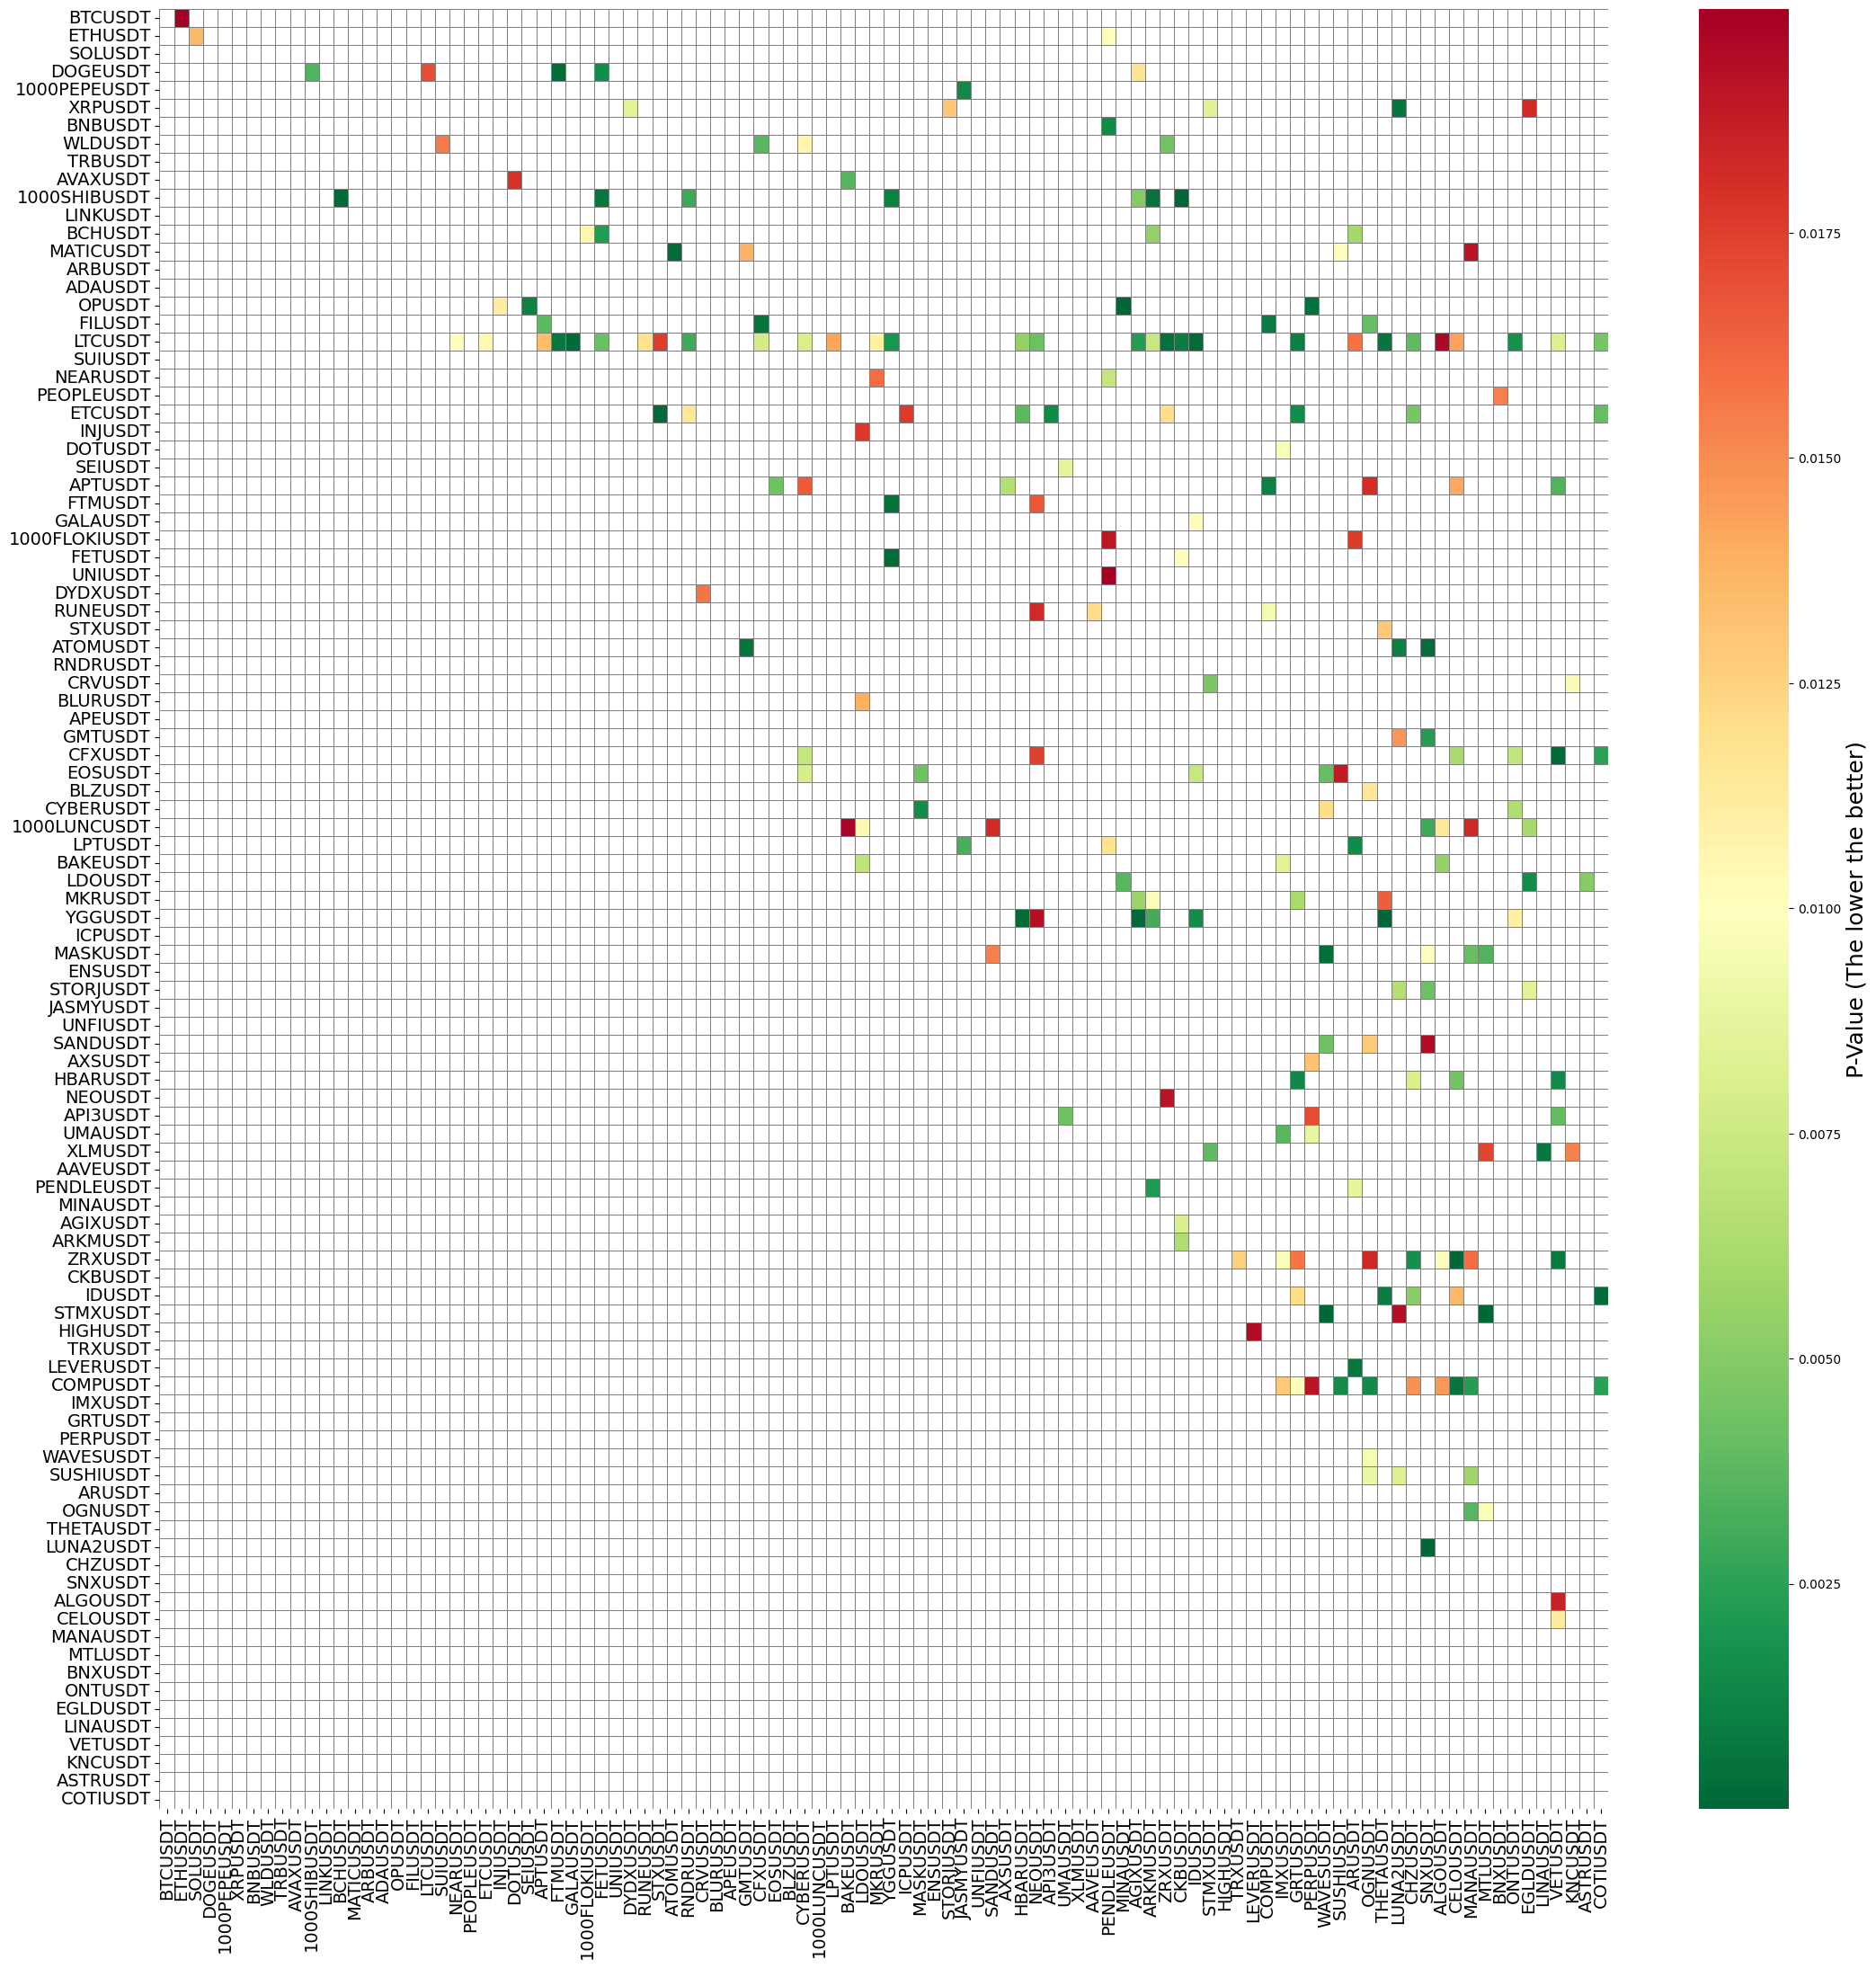

In [31]:
print("\n")

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(pvalues, xticklabels=data_sanitized.keys(),
                      yticklabels=data_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(pvalues > (P_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('P-Value (The lower the better)', size=18)

plt.show()

print("\n")

The bar chart below displays all pairs with a p-value below ***P_VALUE_THRESHOLD***, arranged in descending order of p-value. Consequently, pairs positioned lower in the chart exhibit stronger cointegration. In the chart, the p-value are multiplied by 1000 for better readability.

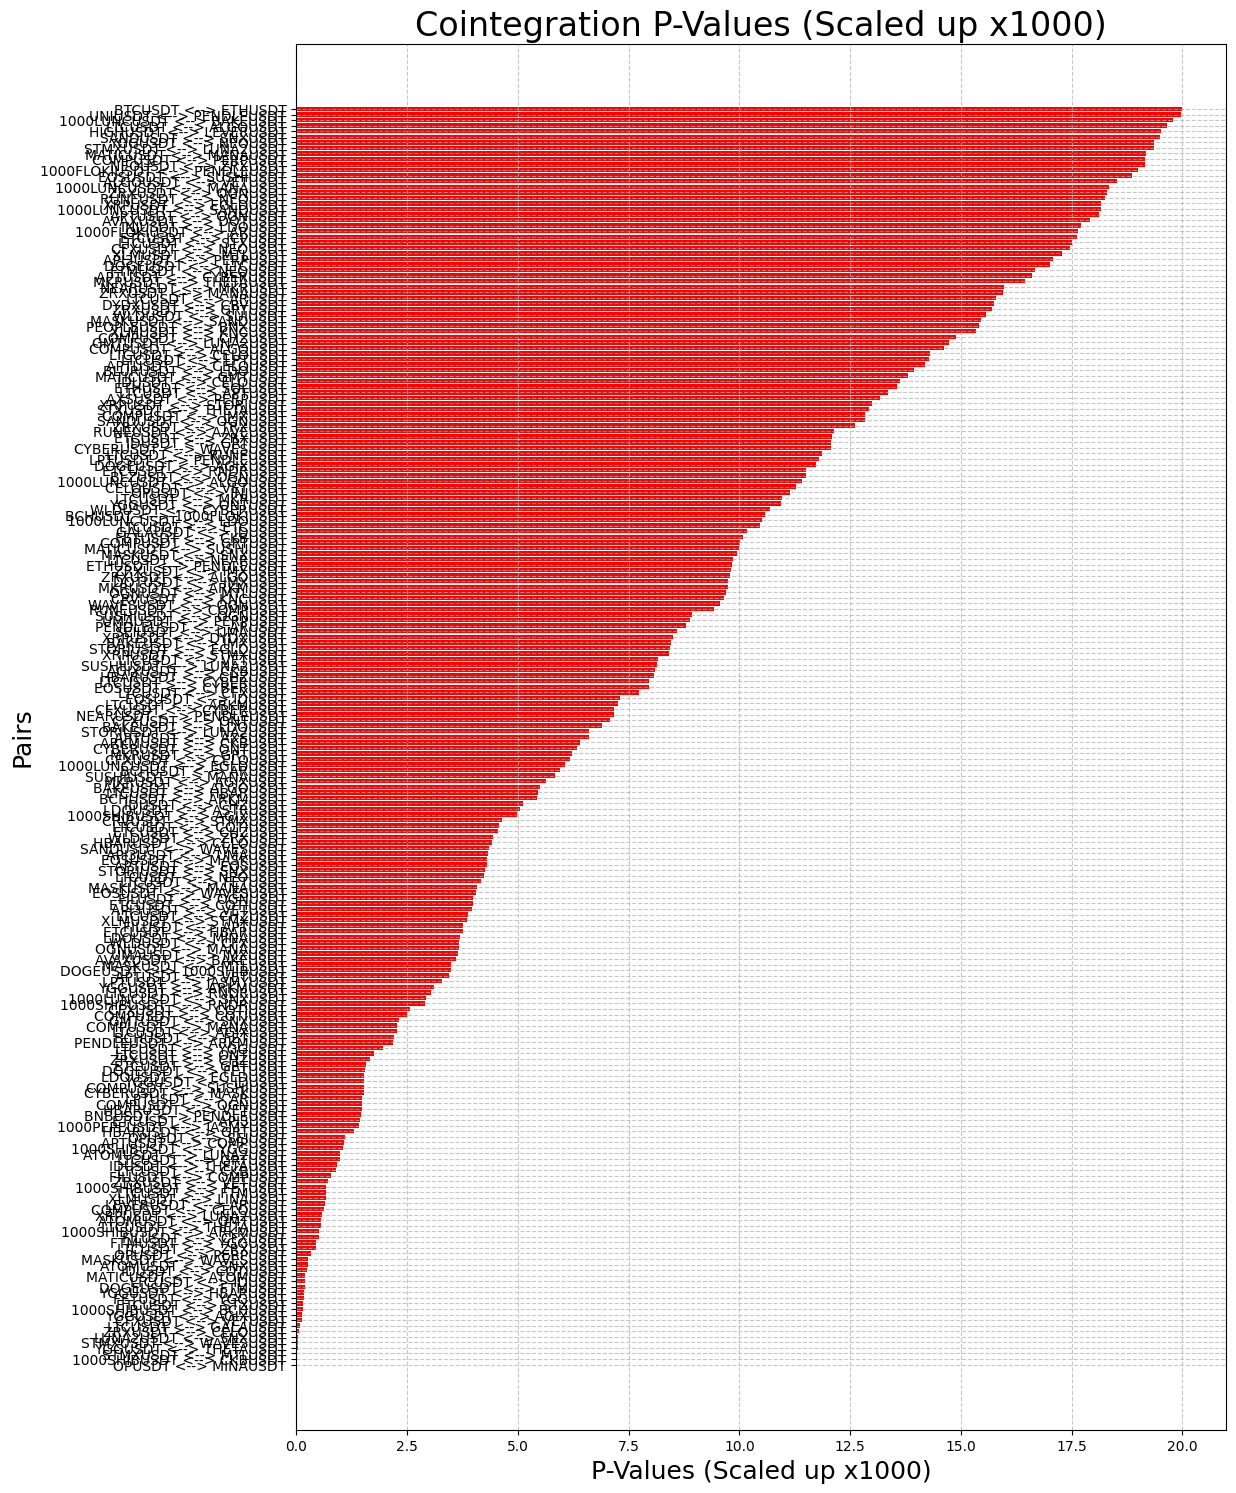

In [32]:
print("\n")

sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sorted_pairs = [x for x in sorted_pairs if x[2] <= P_VALUE_THRESHOLD]
sorted_pairs_labels, pairs_p_values = zip(
    *[(f'{y1} <--> {y2}', p*1000) for y1, y2, p in sorted_pairs])

plt.figure(figsize=(12, 18))
plt.barh(sorted_pairs_labels,
         pairs_p_values, color='red')
plt.xlabel('P-Values (Scaled up x1000)', fontsize=18)
plt.ylabel('Pairs', fontsize=18)
plt.title('Cointegration P-Values (Scaled up x1000)', fontsize=24)

plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

print("\n")

Let's examine their time series using the code provided below. Given the volatile and often small-scale nature of these cryptocurrency instruments, we scale the prices to facilitate comparison with the paired stocks. We will use the ***MinMax*** scaler from sklearn to normalize the closing prices. Additionally, we apply ***rolling window*** smoothing to better visualize the stationarity and relationship between the pairs.

## Select Pairs for Detailed Analysis

- Please select any pair combination from the output below.

In [33]:
print("\nSelectable pairs:")

for pair in sorted_available_pairs:
    print("- {}".format(pair))

print("\n")


Selectable pairs:
- 1000FLOKIUSDT
- 1000LUNCUSDT
- 1000PEPEUSDT
- 1000SHIBUSDT
- AAVEUSDT
- ADAUSDT
- AGIXUSDT
- ALGOUSDT
- APEUSDT
- API3USDT
- APTUSDT
- ARBUSDT
- ARKMUSDT
- ARUSDT
- ASTRUSDT
- ATOMUSDT
- AVAXUSDT
- AXSUSDT
- BAKEUSDT
- BCHUSDT
- BLURUSDT
- BLZUSDT
- BNBUSDT
- BNXUSDT
- BTCUSDT
- CELOUSDT
- CFXUSDT
- CHZUSDT
- CKBUSDT
- COMPUSDT
- COTIUSDT
- CRVUSDT
- CYBERUSDT
- DOGEUSDT
- DOTUSDT
- DYDXUSDT
- EGLDUSDT
- ENSUSDT
- EOSUSDT
- ETCUSDT
- ETHUSDT
- FETUSDT
- FILUSDT
- FTMUSDT
- GALAUSDT
- GMTUSDT
- GRTUSDT
- HBARUSDT
- HIGHUSDT
- ICPUSDT
- IDUSDT
- IMXUSDT
- INJUSDT
- JASMYUSDT
- KNCUSDT
- LDOUSDT
- LEVERUSDT
- LINAUSDT
- LINKUSDT
- LPTUSDT
- LTCUSDT
- LUNA2USDT
- MANAUSDT
- MASKUSDT
- MATICUSDT
- MINAUSDT
- MKRUSDT
- MTLUSDT
- NEARUSDT
- NEOUSDT
- OGNUSDT
- ONTUSDT
- OPUSDT
- PENDLEUSDT
- PEOPLEUSDT
- PERPUSDT
- RNDRUSDT
- RUNEUSDT
- SANDUSDT
- SEIUSDT
- SNXUSDT
- SOLUSDT
- STMXUSDT
- STORJUSDT
- STXUSDT
- SUIUSDT
- SUSHIUSDT
- THETAUSDT
- TRBUSDT
- TRXUSDT
- UMAUSDT
-

### Inputs

In [34]:
##### INPUTS #####
ticker_pairs = [("OPUSDT", "MINAUSDT"), ("1000SHIBUSDT", "CKBUSDT")]
##################

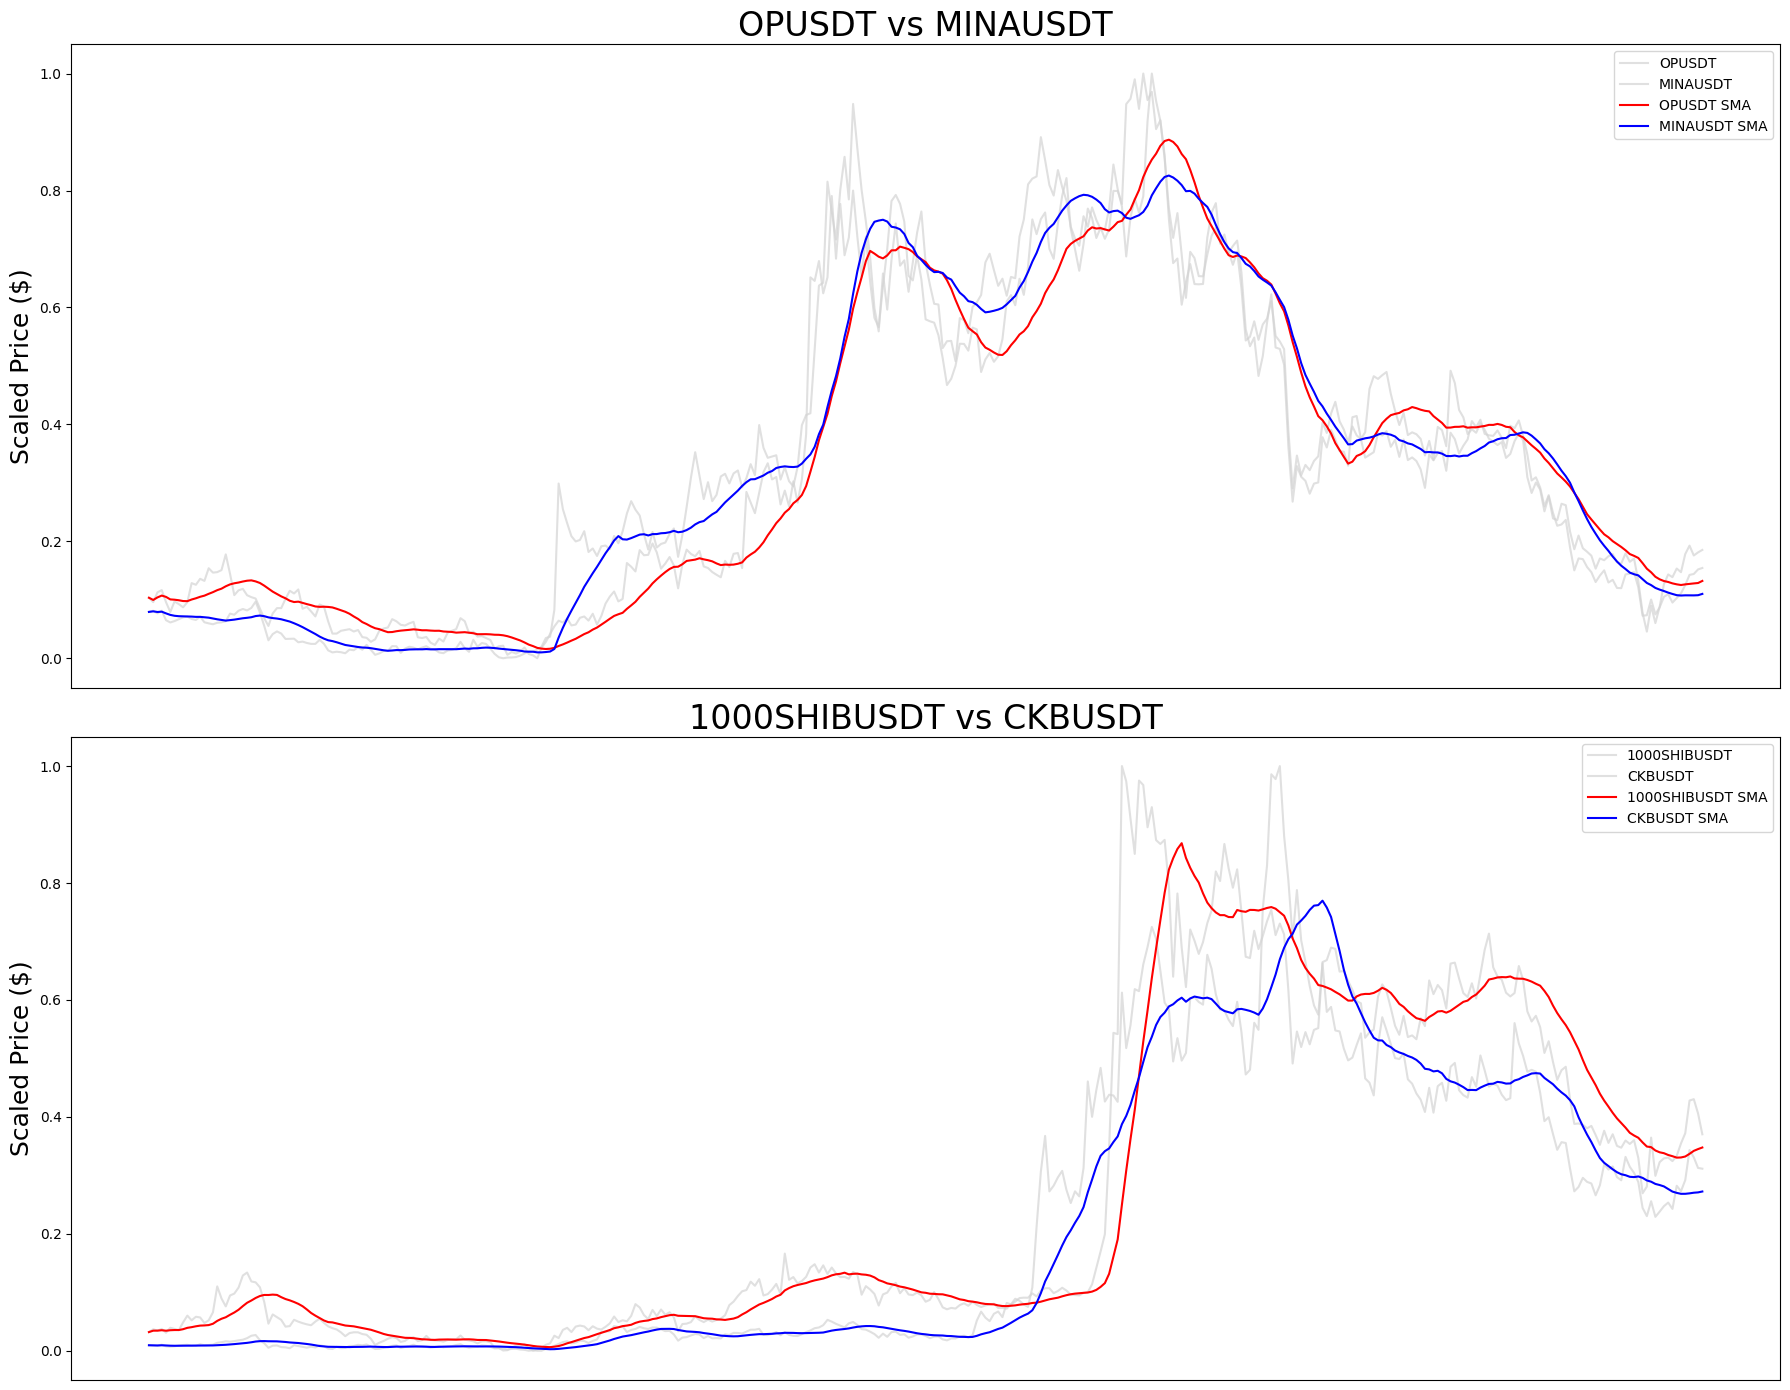

In [35]:
print("\n")

fig, axs = plt.subplots(len(ticker_pairs), 1, figsize=(18, 14))
if len(ticker_pairs) == 1:
    axs = [axs]
scaler = MinMaxScaler()

for i, (ticker1, ticker2) in enumerate(ticker_pairs):

    if ticker1 not in sorted_available_pairs:
        print("{} is not found in the list of selectable pairs. Please choose another one.".format(ticker1))
        if ticker2 not in sorted_available_pairs:
            print("{} is not found in the list of selectable pairs. Please choose another one.\n".format(ticker2))
        continue
        
    if ticker2 not in sorted_available_pairs:
        print("{} is not found in the list of selectable pairs. Please choose another one.".format(ticker2))
        if ticker1 not in sorted_available_pairs:
            print("{} is not found in the list of selectable pairs. Please choose another one.\n".format(ticker1))
        continue
    
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        data_sanitized[ticker1]['Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        data_sanitized[ticker2]['Close'].values.reshape(-1, 1))

    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)

    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()

    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')

    axs[i].set_ylabel('Scaled Price ($)', fontsize=18)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=24)
    axs[i].legend()
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

print("\n")

We will create trading signals using the Z-score and mean. 

The Z-score is denoted as:
$$Z = \frac{X - \mu}{\sigma}$$
1. X is the price we want to standardize.
2. μ is the mean (average) of the rolling window.
3. σ is the standard deviation of the rolling window.

The Z-score measures how far the current ratio of the two asset prices is from its historical mean. 
When the Z-score surpasses a predefined threshold, typically +1 or -1, it generates a trading signal. If the Z-score goes above +1, it indicates that base currency is overvalued compared to the quote currency, signaling a sell for the base currency and a buy for the quote currency. 

Conversely, if the Z-score drops below -1, it suggests the quote currency has become overvalued, prompting a sell for the quote currency and a buy for the base currency. This strategy leverages mean-reversion principles to capitalize on temporary divergences and the expectation of a return to the mean.

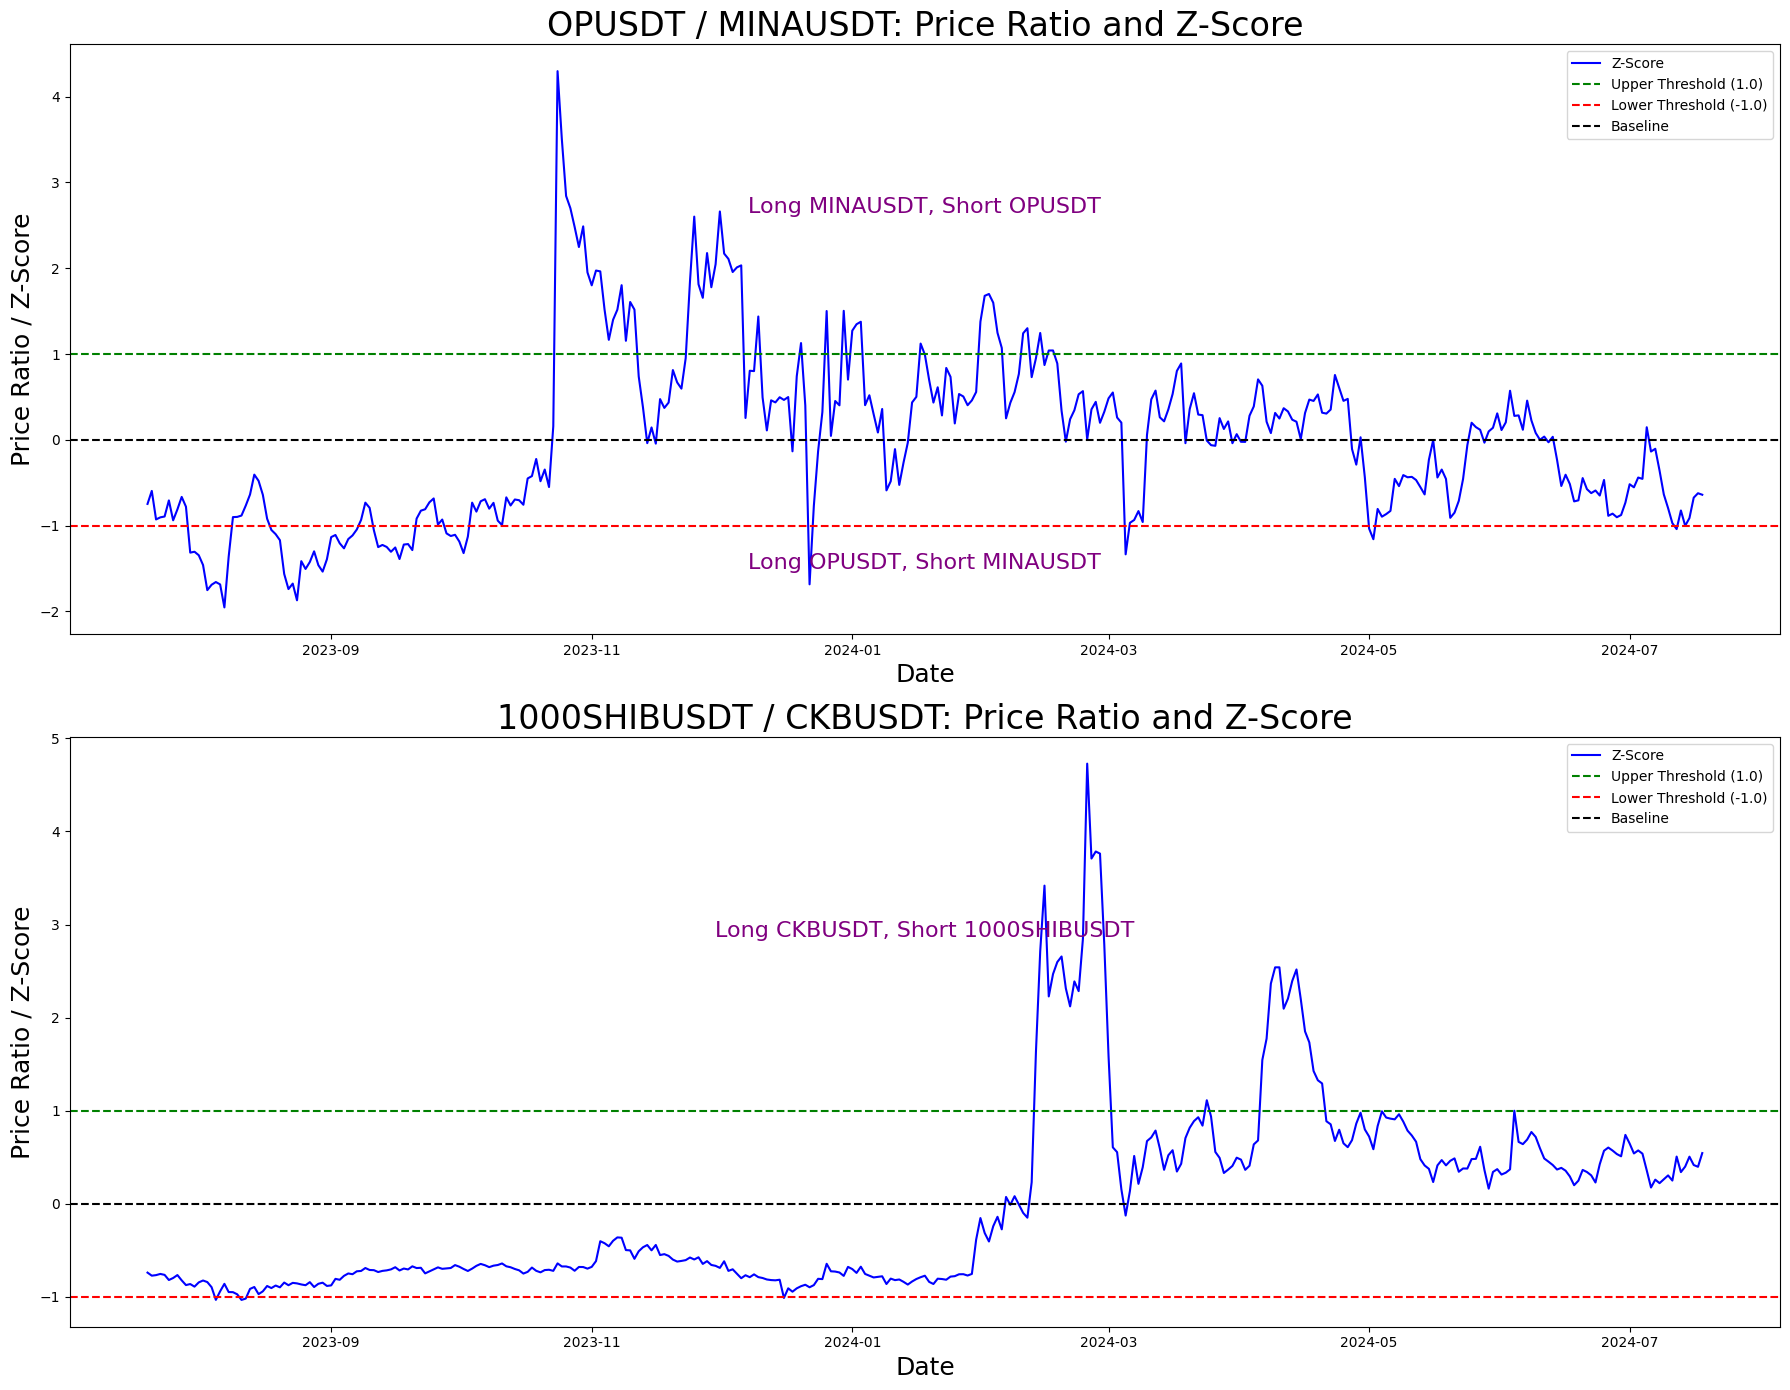

In [36]:
print("\n")

fig, axs = plt.subplots(len(ticker_pairs), 1, figsize=(18, 14))
if len(ticker_pairs) == 1:
    axs = [axs]

for i, (ticker1, ticker2) in enumerate(ticker_pairs):    
    ticker1_ts = data_sanitized[ticker1]["Close"]
    ticker2_ts = data_sanitized[ticker2]["Close"]
    
    # Calculate price ratio (Ticker 1 price / Ticker 2 price)
    ratios = ticker2_ts/ticker1_ts
    
    ratios_mean = np.mean(ratios)
    ratios_std = np.std(ratios)
    ratios_zscore = (ratios - ratios_mean) / ratios_std
    
    axs[i].plot(ratios.index, ratios_zscore, label="Z-Score", color='blue')
    
    # Plot reference lines
    axs[i].axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
    axs[i].axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
    axs[i].axhline(0, color="black", linestyle='--', label="Baseline")

    length = len(ratios.index)
    middle_index = length // 2
    middle_value = ratios.index[middle_index]
    max_ratios_zscore = max(ratios_zscore)
    min_ratios_zscore = min(ratios_zscore)

    if max_ratios_zscore > 2:
        upper_y_text = (max_ratios_zscore + 1) / 2
    else:
        upper_y_text = 1.5

    if min_ratios_zscore < -2:
        lower_y_text = (min_ratios_zscore - 1) / 2
    else:
        lower_y_text = -1.5
    
    axs[i].text(middle_value, upper_y_text, 'Long {}, Short {}'.format(ticker2, ticker1), fontsize = 16, color='purple', horizontalalignment='center', clip_on=True)
    axs[i].text(middle_value, lower_y_text, 'Long {}, Short {}'.format(ticker1, ticker2), fontsize = 16, color='purple', horizontalalignment='center', clip_on=True)
    
    axs[i].set_title('{} / {}: Price Ratio and Z-Score'.format(ticker1, ticker2), fontsize=24)
    axs[i].set_xlabel('Date', fontsize=18)
    axs[i].set_ylabel('Price Ratio / Z-Score', fontsize=18)
    axs[i].legend(loc='upper right')
    
plt.tight_layout()
plt.show()

print("\n")

## Backtest Pair Trading 

Note: The code provided below has not been verified for its intended usage in this context. Please review and test the code thoroughly to ensure it meets your requirements before applying it.

/Users/gordon.oh/Desktop/crypto-pair-trading/utils.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profit[-1] = prices[-1] - prices[bi]
/Users/gordon.oh/Desktop/crypto-pair-trading/utils.py:68: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  profit[-1] = prices[-1] - prices[bi]


<Figure size 2600x1800 with 0 Axes>

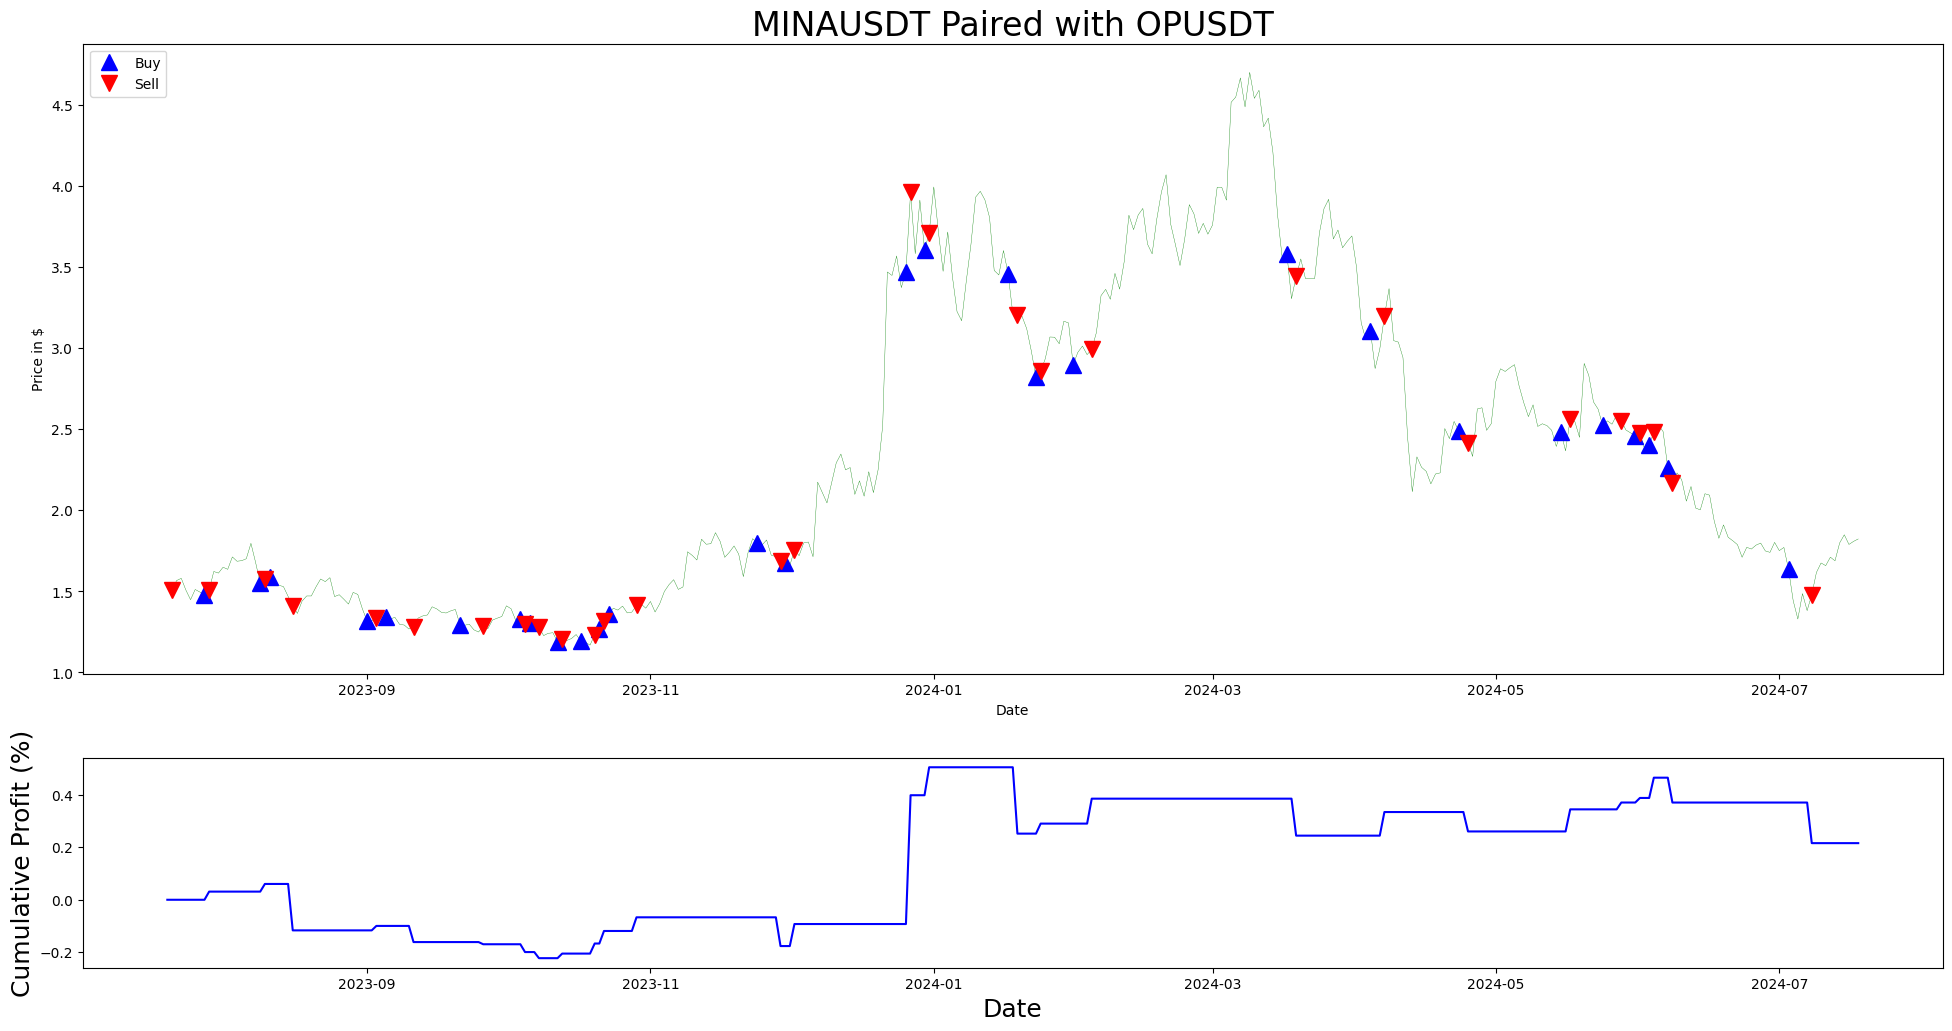

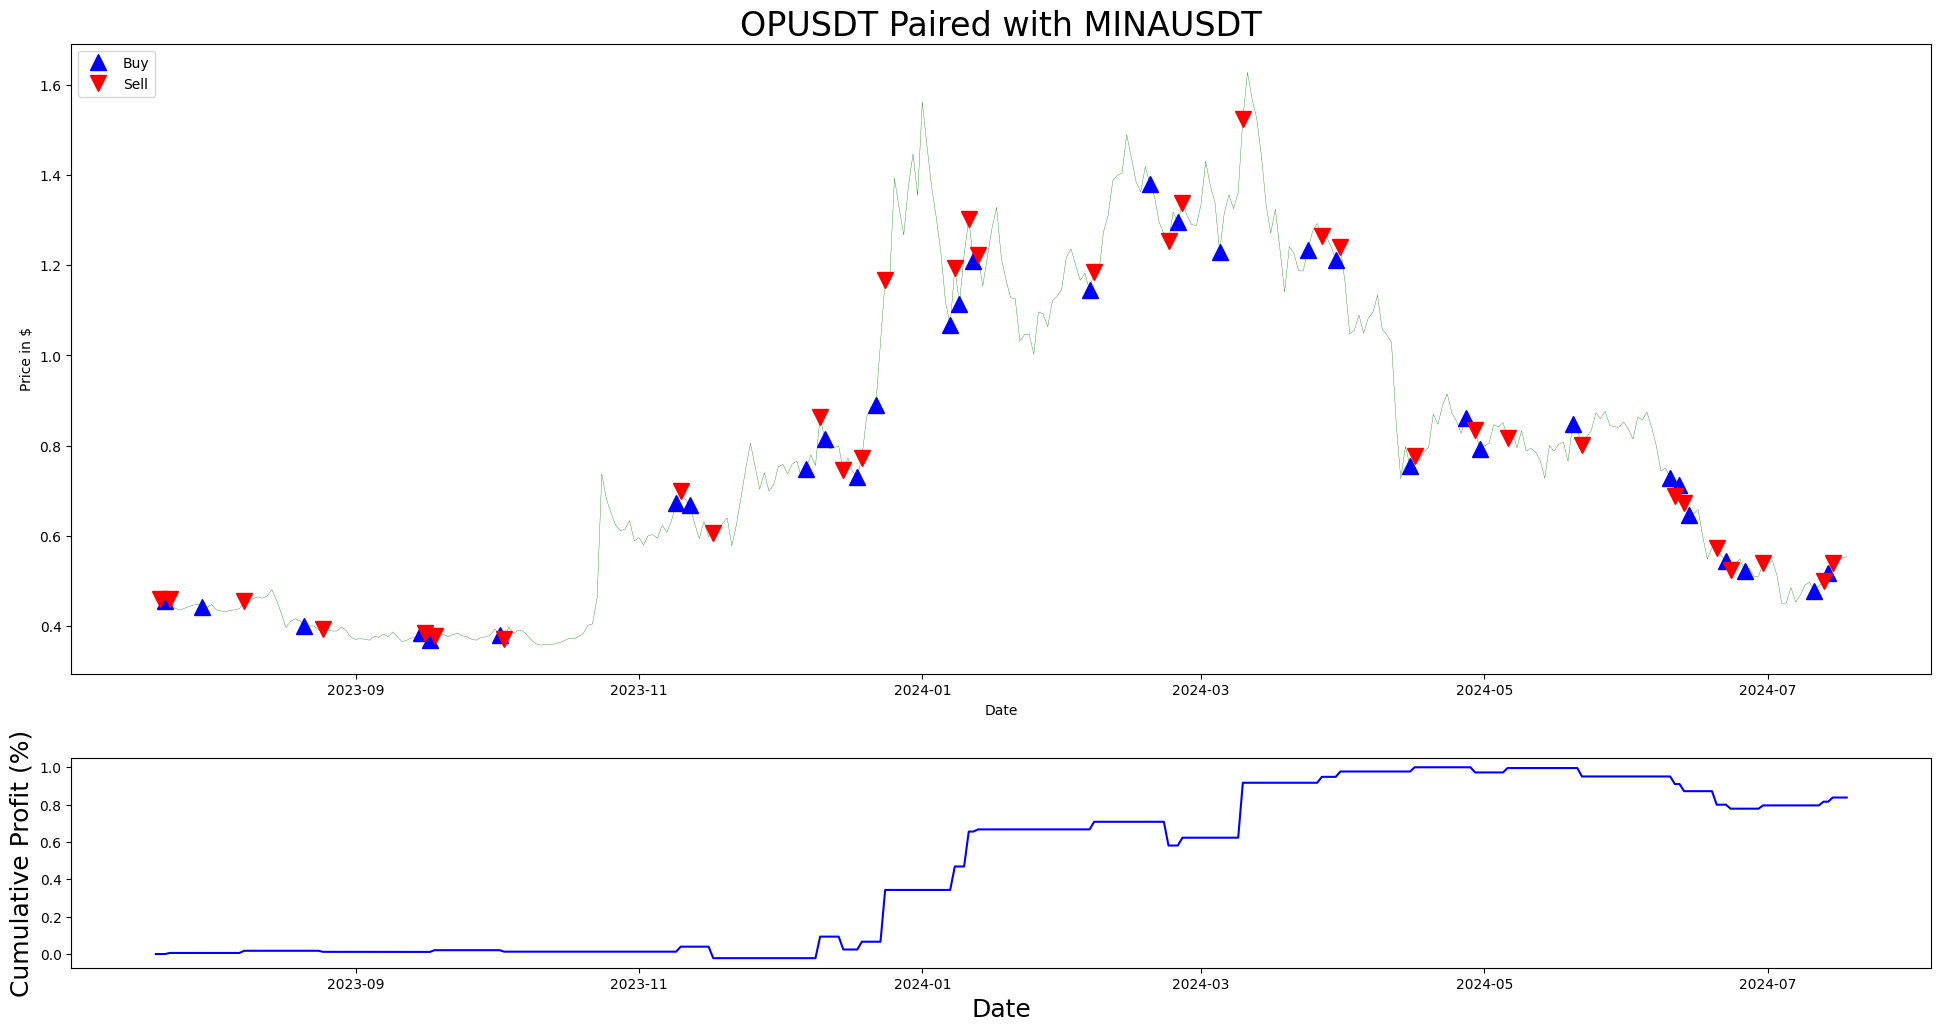

<Figure size 2600x1800 with 0 Axes>

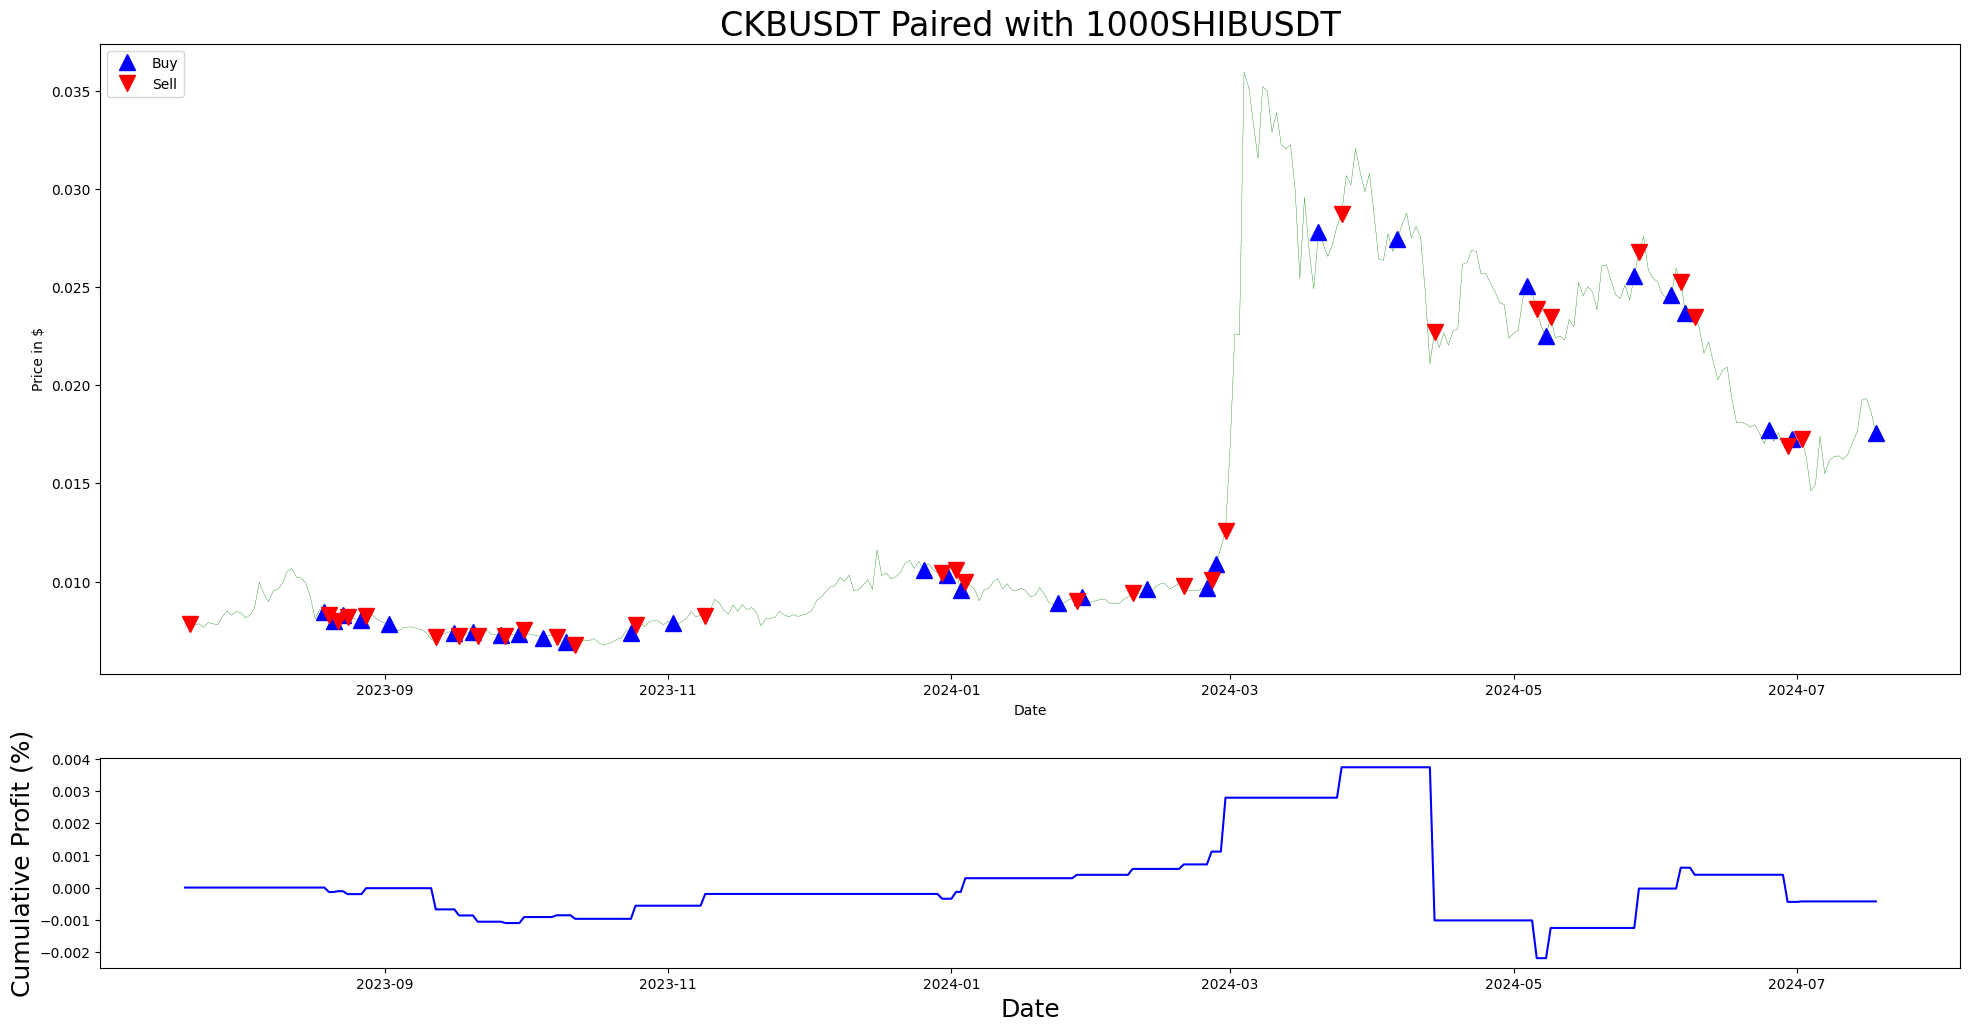

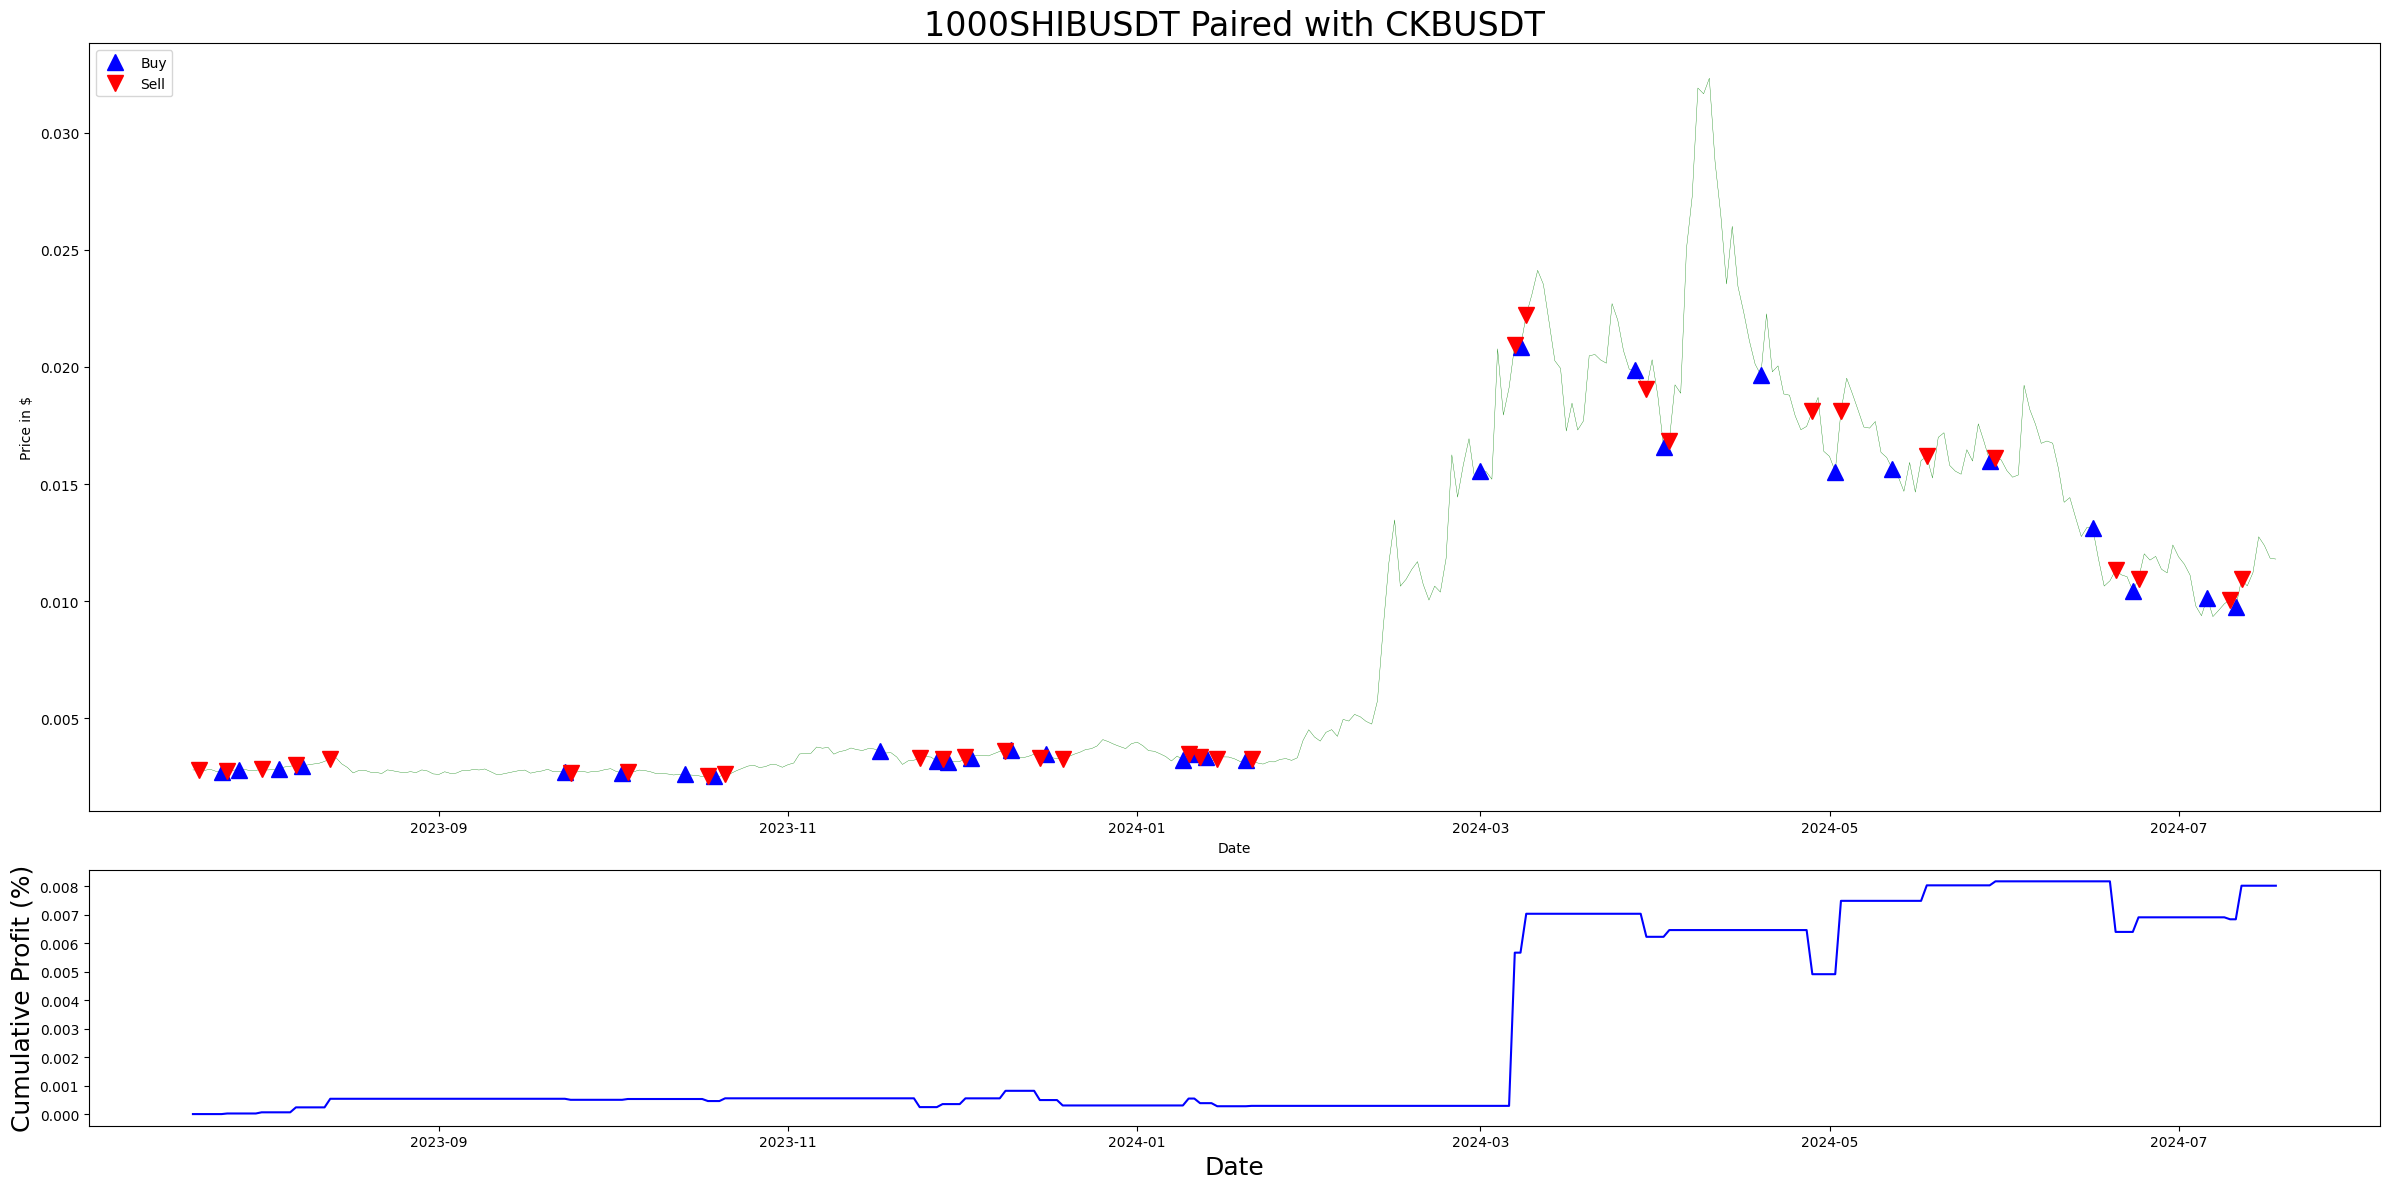

In [37]:
print("\n")

def signals_zscore_evolution(ticker1_ts, ticker2_ts, window_size=15, first_ticker=True):
    """
    Generate trading signals based on z-score analysis of the ratio between two time series.
    Parameters:
    - ticker1_ts (pandas.Series): Time series data for the first security.
    - ticker2_ts (pandas.Series): Time series data for the second security.
    - window_size (int): The window size for calculating z-scores and ratios' statistics.
    - first_ticker (bool): Set to True to use the first ticker as the primary signal source, and False to use the second.

    Returns:
    - signals_df (pandas.DataFrame): A DataFrame with 'signal' and 'orders' columns containing buy (1) and sell (-1) signals.

    """
    ratios = ticker1_ts / ticker2_ts

    ratios_mean = ratios.rolling(
        window=window_size, min_periods=1, center=False).mean()
    ratios_std = ratios.rolling(
        window=window_size, min_periods=1, center=False).std()

    z_scores = (ratios - ratios_mean) / ratios_std

    buy = ratios.copy()
    sell = ratios.copy()

    if first_ticker:
        # These are empty zones, where there should be no signal
        # the rest is signalled by the ratio.
        buy[z_scores > -1] = 0
        sell[z_scores < 1] = 0
    else:
        buy[z_scores < 1] = 0
        sell[z_scores > -1] = 0

    signals_df = pd.DataFrame(index=ticker1_ts.index)
    signals_df['signal'] = np.where(buy > 0, 1, np.where(sell < 0, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df

profit_df1_list = []
profit_df2_list = []

for i, (ticker1, ticker2) in enumerate(ticker_pairs):

    ticker1_ts = data_sanitized[ticker1]["Close"]
    ticker2_ts = data_sanitized[ticker2]["Close"]
    
    plt.figure(figsize=(26, 18))
    signals_df1 = signals_zscore_evolution(ticker1_ts, ticker2_ts)
    profit_df1 = calculate_profit(signals_df1, ticker1_ts)
    profit_df1_list.append(profit_df1)
    ax1, _ = plot_strategy(ticker1_ts, signals_df1, profit_df1)
    
    signals_df2 = signals_zscore_evolution(ticker1_ts, ticker2_ts, first_ticker=False)
    profit_df2 = calculate_profit(signals_df2, ticker2_ts)
    profit_df2_list.append(profit_df2)
    ax2, _ = plot_strategy(ticker2_ts, signals_df2, profit_df2)
    
    ax1.legend(loc='upper left')
    ax1.set_title('{} Paired with {}'.format(ticker2, ticker1), fontsize=24)
    ax2.legend(loc='upper left')
    ax2.set_title('{} Paired with {}'.format(ticker1, ticker2), fontsize=24)

plt.tight_layout()
plt.show()

print("\n")

In an algorithmic trading system, these processes would run concurrently, making it most appropriate to represent the returns as a cumulative sum.

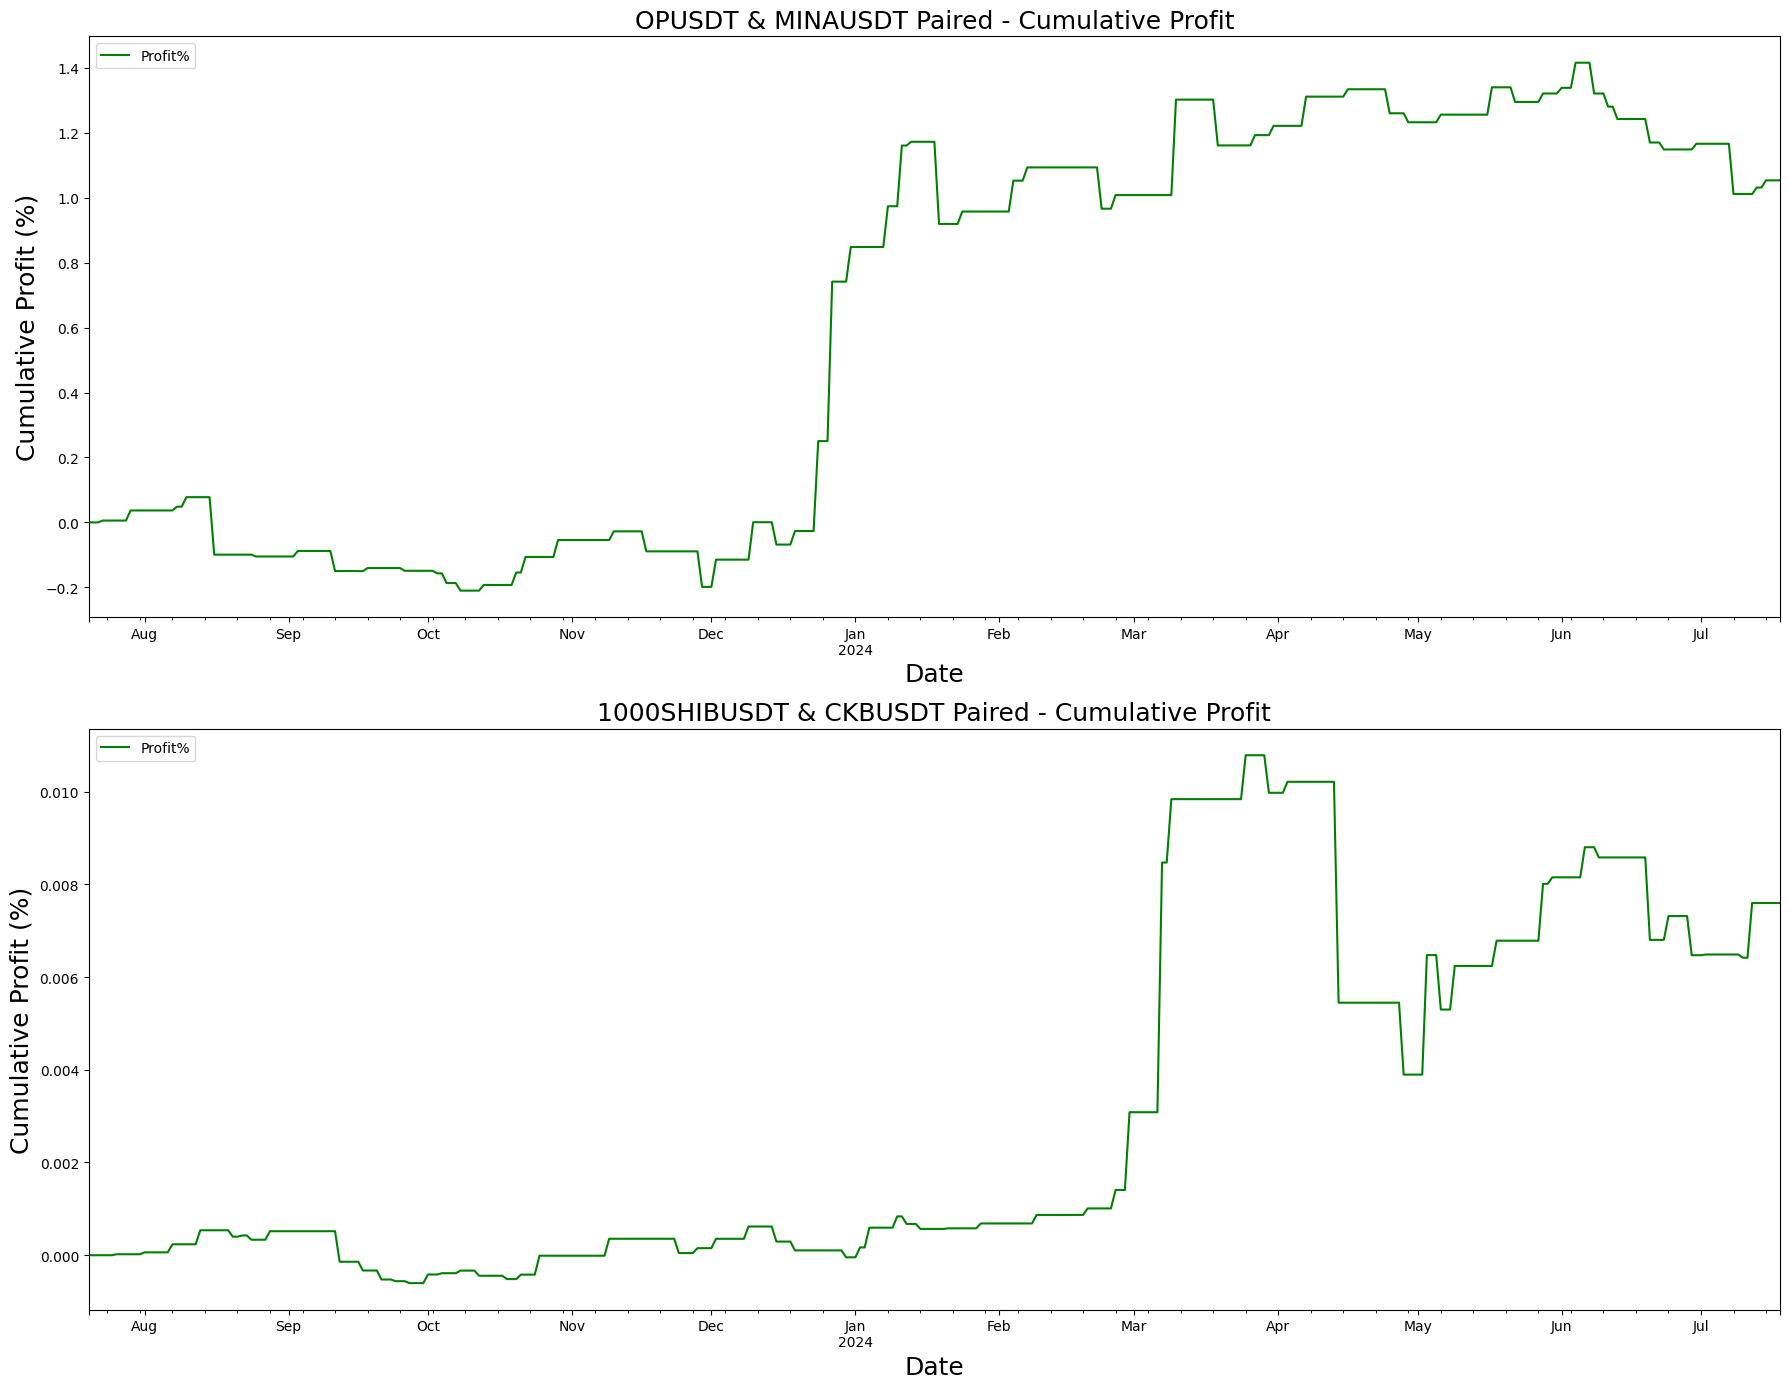

In [38]:
print("\n")

fig, axs = plt.subplots(len(ticker_pairs), 1, figsize=(18, 14))
if len(ticker_pairs) == 1:
    axs = [axs]

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    profit_df1 = profit_df1_list[i]
    profit_df2 = profit_df2_list[i]

    cumulative_profit_combined = profit_df1 + profit_df2
    cumulative_profit_combined.plot(ax=axs[i], label='Profit%', color='green')
    
    axs[i].set_title('{} & {} Paired - Cumulative Profit'.format(ticker1, ticker2), fontsize=18)
    axs[i].set_xlabel('Date', fontsize=18)
    axs[i].set_ylabel('Cumulative Profit (%)', fontsize=18)
    axs[i].legend(loc='upper left', fontsize=10)
    
plt.tight_layout()
plt.show()

print("\n")

# Conclusion

To end this article, we learned about pairs-trading strategy, and saw that it had these attributes:

- **Market-Neutral**: Pair trading strategies aim to be market-neutral, meaning they seek to profit from relative price movements between two assets rather than overall market direction.
- **Statistical Basis**: The strategy relies on statistical measures like the Z-score and cointegration, providing a quantitative foundation for decision-making.
- Mean Reversion: It takes advantage of mean reversion, exploiting the tendency of asset prices to revert to their historical averages. Check out the previous article.

Though in reality, it would have these challenges:

- **Transaction Cost**s: We signaled a lot of trades in our simulation, that would create severe commission and exexution costs.
- **Risk of Non-Stationarity**: If asset correlations or cointegration break down, the strategy will underperform and create risk.

## References

- https://numpy.org/doc/stable/reference/
- https://www.investopedia.com/terms/p/pairstrade.asp 
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html 
- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- https://www.statisticshowto.com/cointegration/
- https://www.linkedin.com/pulse/momentum-reversion-poor-mans-trading-strategies-adam-darmanin-vhrif 

## Github

- The original GitHub notebook is found [here](https://github.com/adamd1985/quant_research/blob/main/pair-trading-quant.ipynb).
- The original Kaggle notebook is found [here](https://www.kaggle.com/addarm/pairs-trading-strategy-quant).
